[*********************100%***********************]  10 of 10 completed


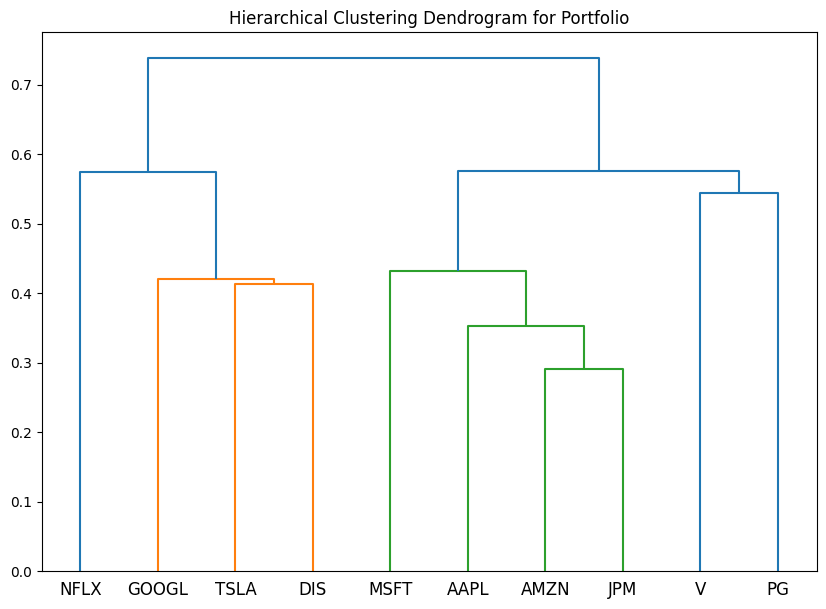

Hierarchical Risk Parity Portfolio Weights:
NFLX: 5.46%
GOOGL: 12.32%
TSLA: 3.20%
DIS: 7.36%
MSFT: 8.94%
AAPL: 11.08%
AMZN: 9.89%
JPM: 11.83%
V: 10.22%
PG: 19.70%


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# Step 1: Download historical stock data
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "JPM", "V", "NFLX", "PG", "DIS"]  # Example tickers
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")['Adj Close']

# Step 2: Calculate daily returns
returns = data.pct_change().dropna()

# Step 3: Calculate the correlation matrix and transform it to a distance matrix
corr_matrix = returns.corr()
distance_matrix = np.sqrt(0.5 * (1 - corr_matrix))

# Step 4: Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=tickers)
plt.title("Hierarchical Clustering Dendrogram for Portfolio")
plt.show()

# Step 5: Hierarchical Risk Parity Portfolio Allocation
def get_cluster_variance(cov_matrix, cluster_items):
    """ Calculate the variance of a cluster. """
    cov = cov_matrix.loc[cluster_items, cluster_items]
    weights = 1 / np.diag(cov)
    weights /= weights.sum()
    return np.dot(weights, np.dot(cov, weights))

def recursive_bisection(cov_matrix, ordered_tickers):
    """ Recursively allocate weights to clusters using hierarchical risk parity. """
    if len(ordered_tickers) == 1:
        return {ordered_tickers[0]: 1}

    # Split into two clusters
    left_cluster = ordered_tickers[:len(ordered_tickers) // 2]
    right_cluster = ordered_tickers[len(ordered_tickers) // 2:]

    # Calculate variances for each cluster
    left_var = get_cluster_variance(cov_matrix, left_cluster)
    right_var = get_cluster_variance(cov_matrix, right_cluster)
    alloc_factor = 1 - left_var / (left_var + right_var)

    # Recursively apply bisection to each cluster
    allocation = {}
    for ticker, weight in recursive_bisection(cov_matrix, left_cluster).items():
        allocation[ticker] = weight * alloc_factor
    for ticker, weight in recursive_bisection(cov_matrix, right_cluster).items():
        allocation[ticker] = weight * (1 - alloc_factor)

    return allocation

# Calculate the covariance matrix
cov_matrix = returns.cov()

# Get tickers in the order of hierarchical clustering
ordered_tickers = [tickers[i] for i in dendrogram(linkage_matrix, labels=tickers, no_plot=True)['leaves']]

# Perform HRP allocation
hrp_weights = recursive_bisection(cov_matrix, ordered_tickers)

# Display portfolio weights
print("Hierarchical Risk Parity Portfolio Weights:")
for ticker, weight in hrp_weights.items():
    print(f"{ticker}: {weight:.2%}")
